# Mini Project
---

**Name:** Varsha.S

---

## Introduction
This project involves building a regression model to predict the cost of luggage bags using multiple features such as height, width, length, and weight capacities. The objective is to implement multiple linear regression using four methods:

* Scikit-learn's Linear Regression
* Batch Gradient Descent (BGD)
* Mini-Batch Gradient Descent
* Stochastic Gradient Descent (SGD)

The models will be evaluated based on R² Score, Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

### Section 1: Importing Required Libraries and Declaring Global Variables

This section imports all the required Python libraries for data processing, modeling, and evaluation. It also sets key global variables such as learning rate, number of training epochs, and batch size (for mini-batch gradient descent). A fixed seed ensures reproducibility.

In [4]:
# ================================================================
# Import Required Libraries
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ================================================================
# Declaring Global Variables
# ================================================================

np.random.seed(42)          # Set random seed for reproducibility
LEARNING_RATE = 0.001       # Learning rate for gradient descent
EPOCHS = 5000               # Number of training iterations
BATCH_SIZE = 16             # Batch size (used only in mini-batch GD)


### Hyperparameter Selection

To ensure a fair comparison between the three custom optimization strategies — **Batch Gradient Descent (BGD)**, **Mini-Batch Gradient Descent (MBGD)**, and **Stochastic Gradient Descent (SGD)** — I used the **same learning rate of 0.001** and **number of epochs as 5000** for all models defined globally.

Before finalizing, I experimented with different combinations of learning rates and epochs. Some combinations resulted in very poor convergence, and in a few cases, produced **negative R² values**, indicating that the model was performing worse than a baseline mean predictor.

After testing several setups, this combination provided **consistently good performance** across all three models, without instability or divergence. Keeping these parameters fixed ensured that the comparison focuses purely on the differences in **gradient descent strategies**, not on tuning advantages.


### Section 2: Data Loading and Initial Preprocessing

This step loads the dataset from an Excel file and prepares it for analysis.  
All feature and target columns are converted to numeric, and any non-numeric or invalid entries are coerced to NaN.  
Missing values are then filled using the mean of each column, as the distributions are fairly symmetric.  

In [7]:
# ================================================================
# Data Loading and Preprocessing
# ================================================================

# Load the dataset from an Excel file
df = pd.read_excel("bags.xlsx")

# Define the feature columns and the target variable
features = ['Weight', 'Weight1', 'Length', 'Height', 'Width']
target = 'Cost'

# Convert all features and the target to numeric values
# Invalid entries (e.g., strings in numeric columns) are set to NaN
df[features] = df[features].apply(pd.to_numeric, errors='coerce')
df[target] = pd.to_numeric(df[target], errors='coerce')

# Fill any missing (NaN) values using the mean of each column
df.fillna(df.mean(numeric_only=True), inplace=True)


### Note on Data Preprocessing

To ensure consistency and handle possible data entry issues, I converted all feature and target columns to numeric types using `pd.to_numeric(errors='coerce')`. This automatically replaced any invalid or non-numeric entries (such as blanks or '$,&,#,U') with NaN.

To handle missing values, I chose **mean imputation** instead of median. Since the distributions of the features are not highly skewed, the mean preserves the central tendency better and retains the numeric scale, which is important for algorithms like linear regression.

Using mean helps retain the overall scale of the data, which is important for gradient-based optimization.


### Section 3: Outlier Removal with Tolerance

This section removes outliers from the dataset using the Interquartile Range (IQR) method,to reduce noise from extreme values while preserving useful variance.  
A tolerance of 15% is applied to widen the IQR bounds slightly, allowing moderately outlying values to remain.  
This strikes a balance between aggressive outlier removal and retaining relevant data for training.

In [10]:
# ================================================================
# Outlier Removal with Tolerance
# ================================================================

tolerance = 0.15  # 15% tolerance buffer

# Calculate the IQR (Interquartile Range) for each feature
Q1 = df[features].quantile(0.25)
Q3 = df[features].quantile(0.75)
IQR = Q3 - Q1

# Define relaxed IQR bounds with tolerance
lower_bound = (Q1 - 1.5 * IQR) * (1 - tolerance)
upper_bound = (Q3 + 1.5 * IQR) * (1 + tolerance)

# Filter the dataset to include only rows within the relaxed bounds
condition = ((df[features] >= lower_bound) & (df[features] <= upper_bound)).all(axis=1)
df = df[condition]


### Section 4: Feature Scaling and Train-Test Split

This section defines the features (X) and target (y), standardizes the feature values using StandardScaler, and then splits the data into training and testing sets using an 80-20 split. Finally, the target arrays are converted to NumPy arrays for compatibility with custom models.


In [12]:
# ================================================================
# Feature Scaling and Train-Test Split
# ================================================================

# Define feature matrix X and target vector y
X = df[features]
y = df[target]

# Standardize the features to have mean = 0 and std = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert target vectors to NumPy arrays
y_train = y_train.values
y_test = y_test.values


### Section 5: Model Evaluation Function

This function evaluates regression model predictions by calculating key performance metrics:
- R² Score to measure explained variance.
- Mean Squared Error (MSE) to penalize large errors.
- Root Mean Squared Error (RMSE) for interpretability in original units.
It also prints a neat summary of the results.

In [14]:
# ================================================================
# Model Evaluation Function
# ================================================================

def evaluate_model(name, y_true, y_pred):
    """
    Evaluates and prints the performance metrics of a regression model.
    
    Parameters:
    - name: str, the model's name
    - y_true: array-like, true target values
    - y_pred: array-like, predicted target values
    
    Returns:
    - r2: float, coefficient of determination
    - mse: float, mean squared error
    - rmse: float, root mean squared error
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{name} Performance:")
    print(f"  R2 Score: {r2:.6f}")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}\n")
    
    return r2, mse, rmse

### Section 6: Coefficient Display Function
This function neatly prints the intercept and coefficients of a linear regression model alongside their corresponding feature names.

In [16]:
# ================================================================
# Coefficient Display Function
# ================================================================

def print_coefficients(name, theta, features):
    """
    Prints the intercept and coefficients of the model.
    
    Parameters:
    - name: str, model name
    - theta: array-like, model parameters where theta[0] is intercept
    - features: list of feature names
    """
    print(f"{name} Coefficients:")
    print(f"  Intercept: {theta[0]:.6f}")
    for i, feature in enumerate(features):
        print(f"  {feature}: {theta[i + 1]:.6f}")
    print()


### Section 7: Helper Function – Add Bias Term

This utility function adds a bias (intercept) term to the feature matrix by prepending a column of 1s. This is required for manual implementations of gradient descent that use a parameter vector including the intercept.


In [18]:
# ================================================================
# Helper Function: Add Bias Term
# ================================================================

def add_bias(X):
    """
    Adds a bias (intercept) column of ones to the feature matrix.
    
    Parameters:
    - X: NumPy array of shape (n_samples, n_features)
    
    Returns:
    - X with an additional first column of ones
    """
    return np.c_[np.ones((X.shape[0], 1)), X] # short for of np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

# Prepare biased feature matrix for test data (used in manual models)
X_test_b = add_bias(X_test)



## Training and Evaluating All Models

Here, all four models (Scikit-learn, BGD, MBGD, and SGD) are trained on the training set and evaluated on the test set.  


### Section 8: Model 1 – Scikit-Learn Linear Regression
This section trains a multiple linear regression model using Scikit-Learn's LinearRegression class. The model is evaluated on the test set, and its performance metrics and learned coefficients are displayed.

In [21]:
# ================================================================
# Model 1: SKLearn Linear Regression
# ================================================================

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate model performance
r2_lr, mse_lr, rmse_lr = evaluate_model("SKLearn Linear Regression", y_test, y_pred_lr)

# Display model coefficients
print("SKLearn Linear Regression Coefficients:")
print(f"  Intercept: {lr_model.intercept_:.6f}")
for feature, coef in zip(features, lr_model.coef_):
    print(f"  {feature}: {coef:.6f}")


SKLearn Linear Regression Performance:
  R2 Score: 0.901296
  MSE: 10042.642090
  RMSE: 100.212984

SKLearn Linear Regression Coefficients:
  Intercept: 397.133271
  Weight: 68.983088
  Weight1: 385.347864
  Length: -260.667378
  Height: 91.033316
  Width: 69.056171


### Section 9: Model 2 – Batch Gradient Descent
This section defines and implements a linear regression model trained using Batch Gradient Descent, where the entire training dataset is used to compute gradients at each iteration.

In [23]:
# ================================================================
# Model 2: Batch Gradient Descent
# ================================================================

def batch_gradient_descent(X, y, lr, epochs):
    """
    Performs linear regression using Batch Gradient Descent.

    Parameters:
    - X: Feature matrix (NumPy array)
    - y: Target values (NumPy array)
    - lr: Learning rate (float)
    - epochs: Number of iterations (int)

    Returns:
    - theta: Learned parameters including intercept (NumPy array)
    """
    X_b = add_bias(X)             # Add bias term to feature matrix
    m, n = X_b.shape
    theta = np.zeros(n)           # Initialize weights to zero

    for epoch in range(epochs):
        gradients = (2/m) * X_b.T.dot(X_b.dot(theta) - y)  # Compute gradients
        theta -= lr * gradients                             # Update weights

    return theta


### Section 10: Training & Evaluating Batch Gradient Descent Model
This section uses the batch_gradient_descent function to train the model, makes predictions on the test data, evaluates the model, and prints the learned coefficients.

In [25]:
# ================================================================
# Training & Evaluating: Batch Gradient Descent
# ================================================================

# Train the model using batch gradient descent
theta_bgd = batch_gradient_descent(X_train, y_train, lr=LEARNING_RATE, epochs=EPOCHS)

# Predict on test data using the learned parameters
y_pred_bgd = X_test_b.dot(theta_bgd)

# Evaluate model performance
r2_bgd, mse_bgd, rmse_bgd = evaluate_model("Batch Gradient Descent", y_test, y_pred_bgd)

# Print learned coefficients
print_coefficients("Batch Gradient Descent", theta_bgd, features)


Batch Gradient Descent Performance:
  R2 Score: 0.902926
  MSE: 9876.818923
  RMSE: 99.382186

Batch Gradient Descent Coefficients:
  Intercept: 397.008554
  Weight: 72.235004
  Weight1: 72.214548
  Length: 57.885568
  Height: 46.739775
  Width: 94.585961



### Section 11: Model 3 – Mini-Batch Gradient Descent
This function implements linear regression using Mini-Batch Gradient Descent, which updates the model weights using small random batches of data at each iteration.

In [27]:
# ================================================================
# Model 3: Mini-Batch Gradient Descent
# ================================================================

def mini_batch_gradient_descent(X, y, lr, epochs, batch_size):
    """
    Performs linear regression using Mini-Batch Gradient Descent.

    Parameters:
    - X: Feature matrix (NumPy array)
    - y: Target values (NumPy array)
    - lr: Learning rate (float)
    - epochs: Number of iterations (int)
    - batch_size: Size of each mini-batch (int)

    Returns:
    - theta: Learned model parameters including intercept (NumPy array)
    """
    X_b = add_bias(X)             # Add bias term
    m, n = X_b.shape
    theta = np.zeros(n)           # Initialize weights

    for epoch in range(epochs):
        indices = np.random.permutation(m)         # Shuffle indices
        X_b_shuffled = X_b[indices]                # Shuffle feature rows
        y_shuffled = y[indices]                    # Shuffle corresponding targets

        for i in range(0, m, batch_size):
            xi = X_b_shuffled[i:i+batch_size]      # Mini-batch features
            yi = y_shuffled[i:i+batch_size]        # Mini-batch targets
            gradients = (2/xi.shape[0]) * xi.T.dot(xi.dot(theta) - yi)
            theta -= lr * gradients                # Update parameters

    return theta


### Section 12: Training & Evaluating Mini-Batch Gradient Descent Model
This section trains the linear regression model using Mini-Batch Gradient Descent, generates predictions on the test set, evaluates the performance, and prints the learned coefficients.

In [29]:
# ================================================================
# Training & Evaluating: Mini-Batch Gradient Descent
# ================================================================

# Train the model using Mini-Batch Gradient Descent
theta_mbgd = mini_batch_gradient_descent(
    X_train, y_train, lr=LEARNING_RATE, epochs=EPOCHS, batch_size=BATCH_SIZE
)

# Predict on test data
y_pred_mbgd = X_test_b.dot(theta_mbgd)

# Evaluate model performance
r2_mbgd, mse_mbgd, rmse_mbgd = evaluate_model("Mini-Batch Gradient Descent", y_test, y_pred_mbgd)

# Print learned coefficients
print_coefficients("Mini-Batch Gradient Descent", theta_mbgd, features)


Mini-Batch Gradient Descent Performance:
  R2 Score: 0.902817
  MSE: 9887.873372
  RMSE: 99.437786

Mini-Batch Gradient Descent Coefficients:
  Intercept: 397.043157
  Weight: 88.628919
  Weight1: 94.230367
  Length: 12.340079
  Height: 49.044185
  Width: 100.481738



### Section 13: Model 4 – Stochastic Gradient Descent (SGD)
This function implements Stochastic Gradient Descent, where model parameters are updated one training example at a time. This can lead to faster convergence on large datasets and introduces useful randomness.

In [31]:
# ================================================================
# Model 4: Stochastic Gradient Descent (SGD)
# ================================================================

def stochastic_gradient_descent(X, y, lr, epochs):
    """
    Performs linear regression using Stochastic Gradient Descent.

    Parameters:
    - X: Feature matrix (NumPy array)
    - y: Target values (NumPy array)
    - lr: Learning rate (float)
    - epochs: Number of iterations (int)

    Returns:
    - theta: Learned model parameters including intercept (NumPy array)
    """
    # NOTE:
    # While mini-batch gradient descent with batch_size=1 appears similar to SGD,
    # this is not exactly equivalent due to scalar-vs-vector broadcasting behavior 
    # in matrix operations. For SGD, each sample is explicitly treated as a 1-row matrix.

    X_b = add_bias(X)  # Add bias term to feature matrix
    m, n = X_b.shape
    theta = np.zeros(n)  # Initialize weights

    for epoch in range(epochs):
        indices = np.random.permutation(m)       # Shuffle dataset
        X_b_shuffled = X_b[indices]
        y_shuffled = y[indices]

        for i in range(m):
            xi = X_b_shuffled[i:i+1]             # Single training example (1, n)
            yi = y_shuffled[i]                   # Scalar target
            error = xi.dot(theta) - yi           # Prediction error (scalar)
            gradients = 2 * xi.T * error         # Gradient vector (n, 1)
            theta -= lr * gradients.flatten()    # Update parameters

    return theta


### Section 14: Training & Evaluating Stochastic Gradient Descent Model
This section trains a linear regression model using Stochastic Gradient Descent, evaluates its performance on the test set, and prints the learned parameters.

In [33]:
# ================================================================
# Training & Evaluating: Stochastic Gradient Descent
# ================================================================

# Train the model using Stochastic Gradient Descent
theta_sgd = stochastic_gradient_descent(X_train, y_train, lr=LEARNING_RATE, epochs=EPOCHS)

# Predict on test data using learned weights
y_pred_sgd = X_test_b.dot(theta_sgd)

# Evaluate model performance
r2_sgd, mse_sgd, rmse_sgd = evaluate_model("Stochastic Gradient Descent", y_test, y_pred_sgd)

# Display model coefficients
print_coefficients("Stochastic Gradient Descent", theta_sgd, features)


Stochastic Gradient Descent Performance:
  R2 Score: 0.901717
  MSE: 9999.809861
  RMSE: 99.999049

Stochastic Gradient Descent Coefficients:
  Intercept: 397.778406
  Weight: 110.531990
  Weight1: 302.332852
  Length: -218.544795
  Height: 85.315523
  Width: 73.075724



### Training Time Observation:

Stochastic Gradient Descent (SGD), while efficient for large datasets due to per-sample updates, required more epochs to converge. This increased the computational time compared to Batch and Mini-Batch Gradient Descent. The trade-off between speed and stability should be considered when choosing an optimization strategy in real-world applications.

**Note:**
Although SGD often converges faster in terms of iteration count on massive datasets, for smaller datasets like this one, its noisy updates can lead to slower convergence and less stable paths toward the optimal solution. Mini-Batch GD often strikes a good balance between convergence speed and computational efficiency.

### Section 15: Formatting Coefficients for All Models
This section prepares the intercept and feature coefficients from all four models as nicely formatted strings for easy comparison.

In [36]:
# ================================================================
# Preparing and Formatting Model Coefficients for Comparison
# ================================================================

# Prepare feature names including intercept
features_with_intercept = ['Intercept'] + features

# Extract coefficients from each model
coef_sklearn = [lr_model.intercept_] + lr_model.coef_.tolist()
coef_bgd = theta_bgd.tolist()
coef_mbgd = theta_mbgd.tolist()
coef_sgd = theta_sgd.tolist()

# Function to format coefficients as 'Feature: value' strings
def format_coefs(coefs):
    return ', '.join([f"{name}: {coef:.3f}" for name, coef in zip(features_with_intercept, coefs)])

# Format coefficients for all models
coef_strs = [
    format_coefs(coef_sklearn),
    format_coefs(coef_bgd),
    format_coefs(coef_mbgd),
    format_coefs(coef_sgd),
]


### Section 16: Summary of Model Performance

This section consolidates the performance metrics (R², MSE, RMSE) and the learned coefficients from all four models — SKLearn Linear Regression, Batch Gradient Descent, Mini-Batch Gradient Descent, and Stochastic Gradient Descent — into a single table for easy comparison.

The table helps in quickly identifying which model performs best and how their coefficients differ.


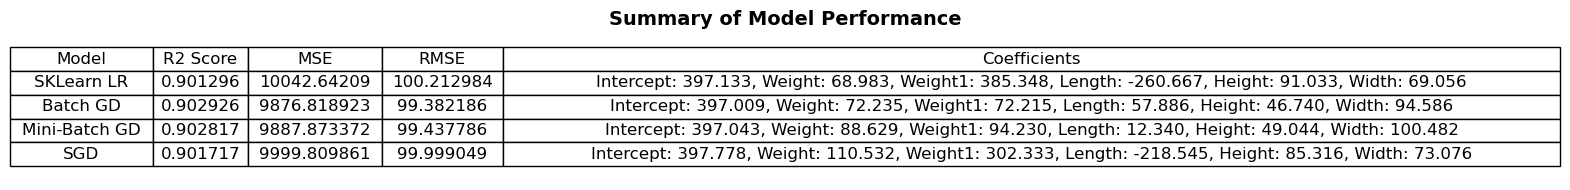

In [38]:
# ================================================================
# Summary of Model Performance
# ================================================================

# List of model names for reference
models = ['SKLearn LR', 'Batch GD', 'Mini-Batch GD', 'SGD']

# Create a DataFrame summarizing key metrics and coefficients for all models
results_df = pd.DataFrame({
    'Model': models,
    'R2 Score': [r2_lr, r2_bgd, r2_mbgd, r2_sgd],   # R-squared values for each model
    'MSE': [mse_lr, mse_bgd, mse_mbgd, mse_sgd],     # Mean Squared Error for each model
    'RMSE': [rmse_lr, rmse_bgd, rmse_mbgd, rmse_sgd], # Root Mean Squared Error for each model
    'Coefficients': coef_strs                         # Model coefficients as formatted strings
})

# Setup matplotlib figure and axis for table display
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('tight')  # Remove axis lines
ax.axis('off')    # Hide axis ticks and labels

# Prepare the data and headers for the table
table_data = results_df.round(6).values.tolist()  # Round data for neat display
column_labels = results_df.columns.tolist()

# Create a table within the plot area
table = ax.table(
    cellText=table_data,
    colLabels=column_labels,
    colLoc='center',
    cellLoc='center',
    loc='center'
)

# Adjust font size and scaling for better readability
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

# Auto-adjust the width of columns to fit content
table.auto_set_column_width(col=list(range(len(column_labels))))

# Add a title for the table
plt.title("Summary of Model Performance", fontweight='bold', fontsize=14)

# Ensure layout fits well
plt.tight_layout()

# Display the table plot
plt.show()


### Section 17: Plotting Model Coefficients Comparison

This section visualizes the coefficients (including intercept) learned by all four models — SKLearn Linear Regression, Batch Gradient Descent, Mini-Batch Gradient Descent, and Stochastic Gradient Descent — side by side.  
The bar plot helps compare how each model weighs the features differently. It shows how each method assigns importance to different features.  
Notably, although model performance is similar, the coefficient values vary—suggesting different convergence paths.


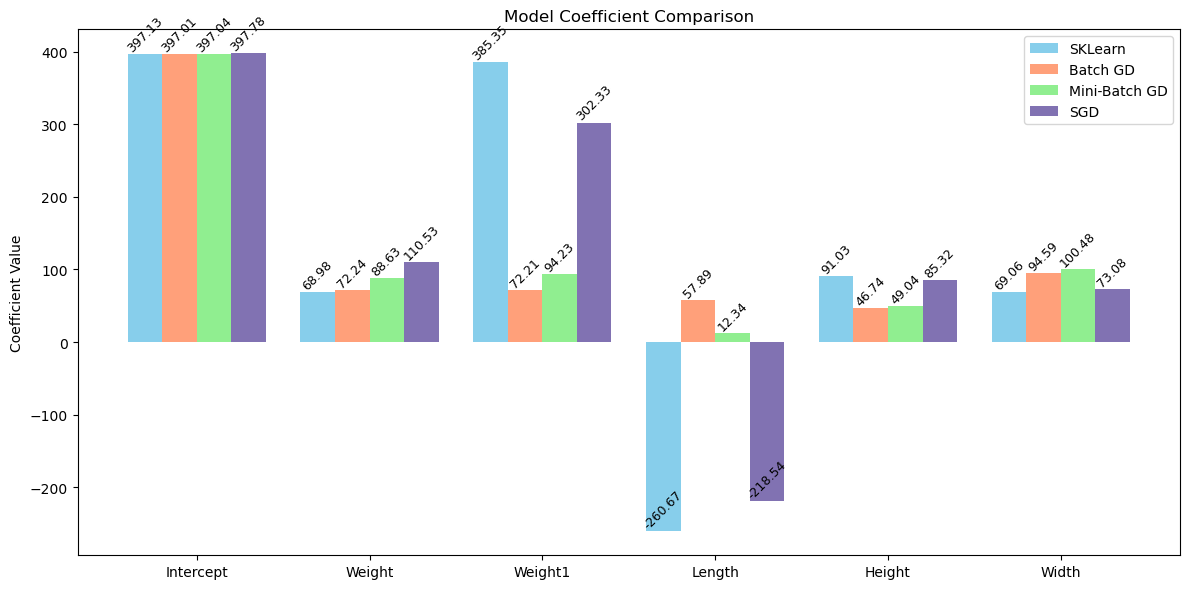

In [40]:
# ================================================================
# Section 17: Plotting Model Coefficients Comparison
# ================================================================

def plot_coefficients(lr_model, theta_bgd, theta_mbgd, theta_sgd, features):
    # Prepare labels including intercept and features
    labels = ['Intercept'] + features

    # Collect coefficients from all models in order
    coef_sklearn = [lr_model.intercept_] + lr_model.coef_.tolist()
    coef_bgd = theta_bgd.tolist()
    coef_mbgd = theta_mbgd.tolist()
    coef_sgd = theta_sgd.tolist()

    all_coefs = [coef_sklearn, coef_bgd, coef_mbgd, coef_sgd]
    model_names = ['SKLearn', 'Batch GD', 'Mini-Batch GD', 'SGD']
    colors = ['skyblue', 'lightsalmon', 'lightgreen', '#8172B2']  # Distinct colors for clarity

    x = np.arange(len(labels))  # X locations for groups
    width = 0.2  # Width of each bar

    plt.figure(figsize=(12, 6))  # Figure size for clear visibility

    # Plot bars for each model with offsets
    for i, (model_name, coef_vals, color) in enumerate(zip(model_names, all_coefs, colors)):
        bars = plt.bar(x + i * width, coef_vals, width=width, label=model_name, color=color)

        # Annotate each bar with the coefficient value
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # X position at bar center
                height,                             # Y position just above bar
                f'{height:.2f}',                    # Display coefficient rounded to 2 decimals
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=45                        # Rotated for better fit
            )

    # Set x-axis labels and formatting
    plt.xticks(x + 1.5 * width, labels, rotation=0)
    plt.ylabel("Coefficient Value")
    plt.title("Model Coefficient Comparison")
    plt.legend()
    plt.tight_layout()  # Adjust layout to fit labels and legend neatly
    plt.show()

# Call the plotting function with model parameters
plot_coefficients(lr_model, theta_bgd, theta_mbgd, theta_sgd, features)


### Section 18: Visualization of Actual vs Predicted Costs
  
This section visualizes the performance of all four models by plotting the actual cost values against the predicted values.  
Each subplot has a green dashed line which represents the ideal predictions, and the scatter distribution shows how closely the models approximate it.


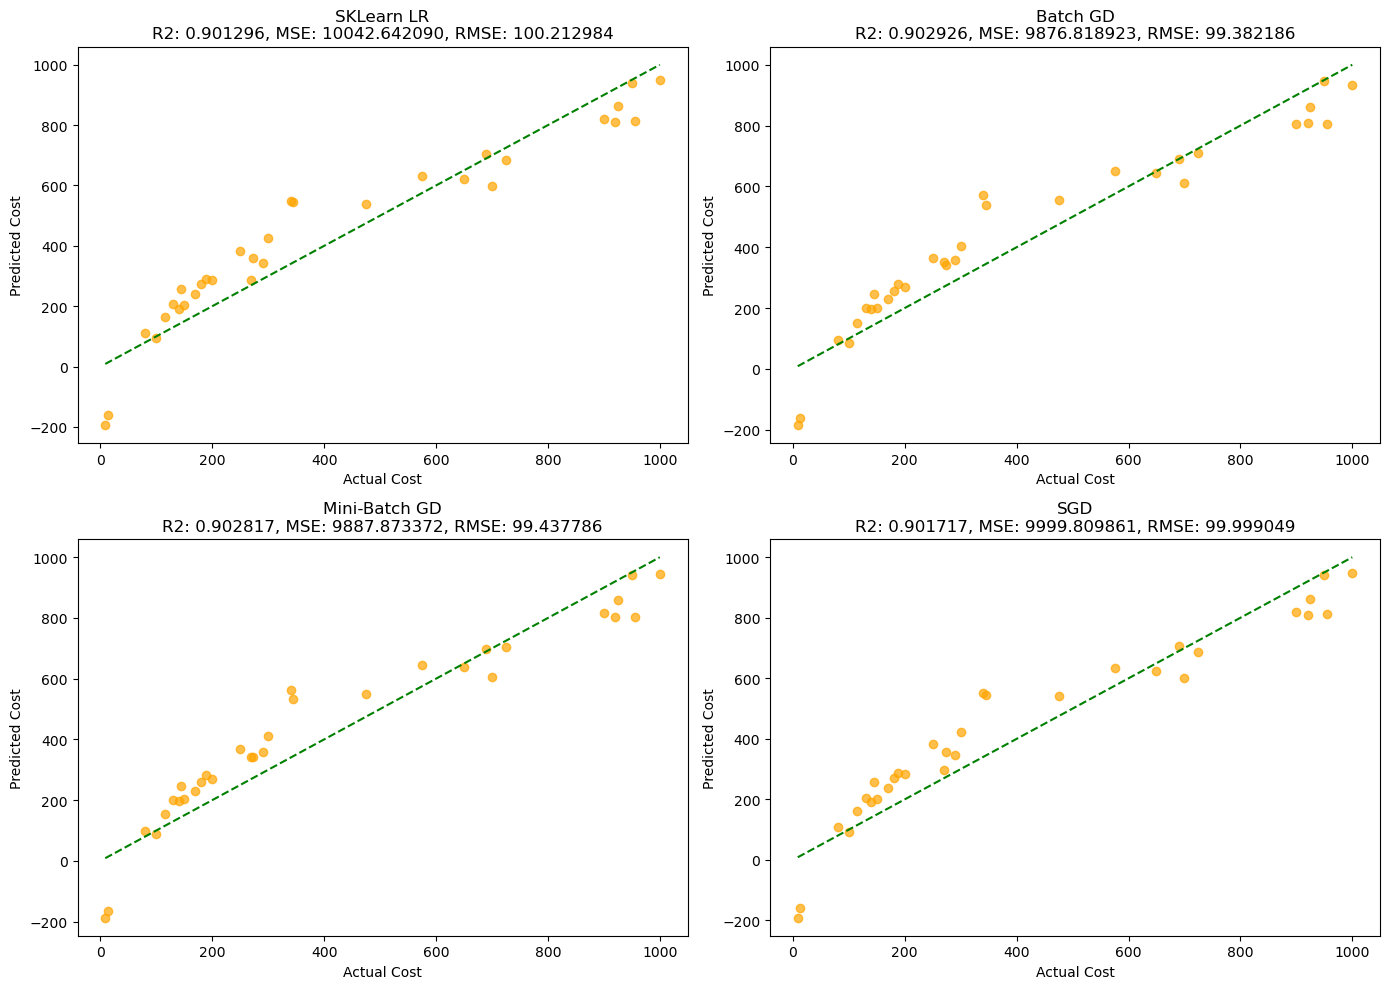

In [42]:
# ================================================================
# Section 18: Visualization of Actual vs Predicted Costs
# ================================================================

plt.figure(figsize=(14, 10))  # Setup figure size for 4 subplots

# List of predictions from each model in order
y_preds = [y_pred_lr, y_pred_bgd, y_pred_mbgd, y_pred_sgd]

# Loop through each model to create subplot
for i, (index, row) in enumerate(results_df.iterrows(), 1):
    model_name = row['Model']
    r2 = row['R2 Score']
    mse = row['MSE']
    rmse = row['RMSE']
    y_pred_vals = y_preds[i - 1]

    plt.subplot(2, 2, i)  # Create 2x2 grid of plots
    plt.scatter(y_test, y_pred_vals, alpha=0.7, color='orange')  # Plot actual vs predicted points
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--')  # Diagonal reference line
    plt.xlabel('Actual Cost')
    plt.ylabel('Predicted Cost')
    plt.title(f'{model_name}\nR2: {r2:.6f}, MSE: {mse:.6f}, RMSE: {rmse:.6f}')  # Display metrics in title

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()          # Display the plots


### Section 19: Bar Plots for Performance Metrics Comparison 

This section visualizes and compares the performance metrics — R² Score, Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) — of all models using side-by-side bar plots.  
Each plot includes labels above bars for precise metric values.


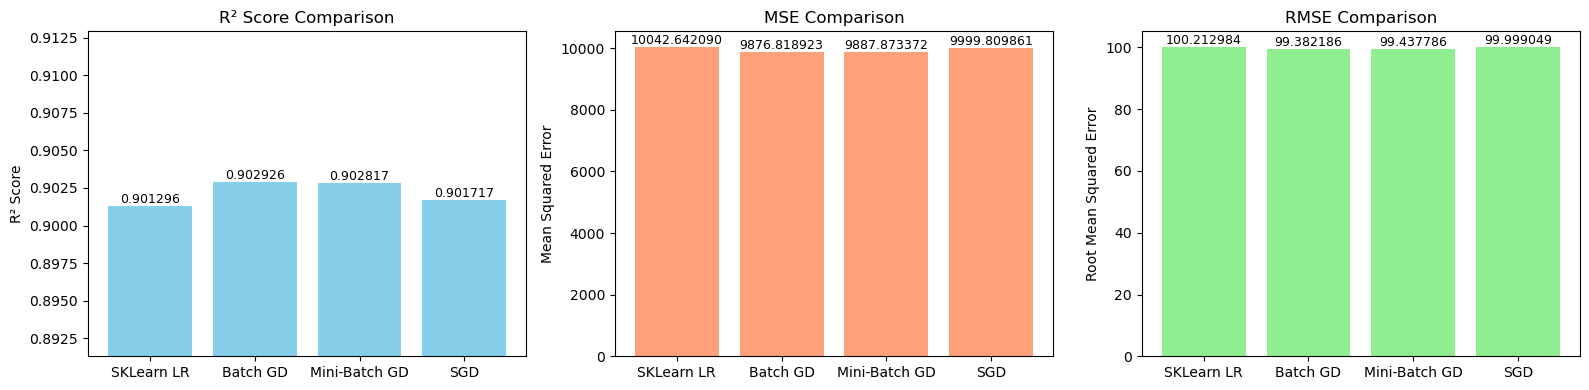

In [44]:
# ================================================================
# Section 19: Bar Plots for Performance Metrics Comparison
# ================================================================

def add_labels(ax, values):
    # Add value labels on top of each bar for clarity
    for i, v in enumerate(values):
        ax.text(i, v, f"{v:.6f}", ha='center', va='bottom', fontsize=9)
        
plt.figure(figsize=(16, 4))  # Set overall figure size

# Plot R² Scores for all models
plt.subplot(1, 3, 1)
plt.bar(results_df['Model'], results_df['R2 Score'], color='skyblue')
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
add_labels(plt, results_df['R2 Score'])
# Set y-limits slightly beyond min/max for better visual spacing
plt.ylim(results_df['R2 Score'].min() - 0.01, results_df['R2 Score'].max() + 0.01)

# Plot Mean Squared Error (MSE) for all models
plt.subplot(1, 3, 2)
plt.bar(results_df['Model'], results_df['MSE'], color='lightsalmon')
plt.title('MSE Comparison')
add_labels(plt, results_df['MSE'])
plt.ylabel('Mean Squared Error')

# Plot Root Mean Squared Error (RMSE) for all models
plt.subplot(1, 3, 3)
plt.bar(results_df['Model'], results_df['RMSE'], color='lightgreen')
plt.title('RMSE Comparison')
add_labels(plt, results_df['RMSE'])
plt.ylabel('Root Mean Squared Error')

plt.tight_layout()  # Adjust layout for neatness
plt.show()


### Section 20: Observations & Model Insights  

This section summarizes the key insights and reflections drawn from the performance of all four models. It discusses the error metrics, convergence characteristics, coefficient variability, and trade-offs between training time and accuracy.

### Overall Performance Comparison

All four models — SKLearn Linear Regression, Batch Gradient Descent, Mini-Batch Gradient Descent, and Stochastic Gradient Descent — achieved **R² scores around 0.90**, indicating strong predictive capabilities.

### Key Observations:
- **Best Performing Model:**  
  Batch Gradient Descent achieved the **highest R² (0.9029)** and **lowest RMSE (99.38)**, demonstrating the most stable and accurate convergence.

- **Mini-Batch Gradient Descent:**  
  Performed nearly as well as Batch GD, providing a good balance between computational efficiency and accuracy.

- **Stochastic Gradient Descent (SGD):**  
  Required more iterations to converge and exhibited slightly higher RMSE due to higher update variance. Despite this, it still performed strongly (R² ≈ 0.9017).

- **SKLearn Linear Regression:**  
  Served as a reliable baseline to validate the manual gradient descent implementations.


### Note on Coefficient Analysis

Although all models performed well, there were **notable differences** in the coefficients they learned. For example, the **'Length'** and **'Weight1'** coefficients varied significantly across models.

This variability highlights how different optimization strategies may converge to different solutions, particularly in the presence of **multicollinearity** or **sensitive feature interactions**.


## Final Conclusion

This section concludes the notebook by summarizing the comparison between the four modeling approaches and discussing the trade-offs between accuracy and computational efficiency.

This mini project demonstrated the implementation and comparison of various optimization techniques for linear regression.

- All gradient descent variants—**Batch**, **Mini-Batch**, and **Stochastic**—achieved strong predictive performance.
- **Batch GD** performed the best overall on this dataset.
- Careful preprocessing steps such as mean imputation and tolerant outlier removal contributed to cleaner data and improved model accuracy.
- Variation in coefficients across methods highlighted model sensitivity to optimization paths, especially in the presence of multicollinearity.
- Consistent learning rates and epochs ensured a **fair and controlled comparison** among all methods.

In practice, **Mini-Batch GD** offers the best trade-off between performance and computational efficiency, while **SGD** is suitable for large-scale datasets. For simplicity and reliability, **SKLearn’s Linear Regression** remains a robust benchmark.
